# Constrained Optimization of the Full Transmon Model

In [1]:
import os
from os.path import join
import sys
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from mgplottools.mpl import set_axis

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2

$\newcommand{\Op}[1]{\boldsymbol{\mathsf{\hat{#1}}}}$
$\newcommand{\ket}[1]{\vert{#1}\rangle}$
$\newcommand{\trace}{\operatorname{tr}}$

## Introduction

We consider the full Transmon Hamiltonian
\begin{equation}
  \Op{H} = \sum_{q=1,2} \left[ \omega_q \Op{b}^{\dagger}_q \Op{b}_q
    + \frac{\alpha_q}{2} \Op{b}^{\dagger}_q\Op{b}^{\dagger}_q\Op{b}_q\Op{b}_q
    + g_q \left(\Op{b}^{\dagger}_q \Op{a} + \Op{b}_q \Op{a}^{\dagger} \right)
    \right]
    + \omega_c \Op{a}^{\dagger}\Op{a}
    + \epsilon(t) \Op{a} + \epsilon^{*}(t) \Op{a}^{\dagger}
\end{equation}
Note that unlike in the optimizations done for KITP in 2013, we do *not* have a static qubit-qubit coupling, outside the effective coupling that is mediated by the cavity

Goals:

1.  Scan the parameter regime systematically for the point that allows the
    easiest implementation of both single- and two-qubit gates. Identify
    known gate mechanisms on map. The scan shows:
    *   Which parameters yield the fastest gates
    *   Which local equivalence classes different qubit parameters lead to
    *   Whether there are "good" regions in addition to the regions at which known gate mechanism have been implemented (determined by resonance conditions)

2.  For select points, determine the quantum speed limit for high fidelity
    gates: What are the fastest possible quantum gates with all-microwave control of transmon qubits 
3.  Include robustness with respect to dissipation, and fluctuations in the
    qubit parameters (as a possible future extension)

Plan:
    
*   Scan parameter space.

    We choose $\omega_1$, $\alpha_1 \neq \alpha_2$, $g_1 = g_2$ constant. We vary $\omega_2$ and $\omega_c$ (in the RWA) on a grid. At each grid point (set of paremters), we perform the following steps to evaluate the parameters as a candidate:
    
    *   Set the gate duration to a constant value, starting from $T=200$ ns and the progressively setting it lower
    *   Determine a good guess pulse for the optimization towards a perfect entangler, and for the optimization towards a single-qubit gate
    *   Perform a Krotov or LBFGS optimization, for PE and for single qubit gates (either LI-optimization for identity, or two optimizations $\sigma_x^{(1)}$ and $\sigma_x^{(2)}$.
    
    The critical step is the determination of a good guess pulse. A possiblity is to generate simple guess pulses based on some randomized parameters, and to perform a few simplex steps in these parameters.
    
*  Pick several points in the parameter space that yielded the best success. Determin the QSL by optimizing at increasingly smaller values of $T$.
    

## Environment Setup

In [5]:
%install_ext http://raw.github.com/goerz/version_information/master/version_information.py
%reload_ext version_information
% version_information numpy, matplotlib, pandas, QDYN, QDYNTransmonLib, "cd $PREFIX/src/qdyn && git log",  "cd $PREFIX/src/transmon_oct && git log"

Installed version_information.py. To use it, type:
  %load_ext version_information


Software,Version
Python,2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython,3.2.1
OS,Darwin 15.2.0 x86_64 i386 64bit
numpy,1.9.2
matplotlib,1.4.3
pandas,0.16.2
QDYN,0.1.6
QDYNTransmonLib,1.0.3
cd $PREFIX/src/qdyn && git log,commit 28d4b4650ec062f00c8ff11179aa276a5cffa9bc
cd $PREFIX/src/transmon_oct && git log,commit 7515584cfa43c00b7482fa419a379e0a9ef606c6


In [6]:
PREFIX = join(os.getcwd(), 'venv')
assert os.path.samefile(join(PREFIX, 'bin'), os.environ['PATH'].split(os.pathsep)[0])

Note that in this overview, we will run all jobs on a local cluster (i.e., a slurm cluster running on the same computer as the notebook server. You may change to the AG Koch (Kassel) cluster by modifying the following options:

In [7]:
cluster_args = '--local --parallel=38 --jobs=1'

For for using other clusters, you will manually have to edit the python scripts that run all the stages below.

## Prerequisites

*   [Does state-dependent constraint work?](Prereq_Nonherm.ipynb) Yes, but slow convergence
*   [Can we ensure a small nq,nc? What sampling rate is sufficient?](Prereq_Cutoff.ipynb) One extra level is sufficient. 100 samples per oscillation is sufficient if we don't claim high precision

## Qubit Paramters

*   $\omega_1/2\pi =$ 6.0 GHz
*   $\omega_2/2\pi$:  varies
*   $\omega_c/2\pi$: varies
*   $\alpha_1/2\pi =$ 290 MHz
*   $\alpha_2/2\pi =$ 310 MHz
*   $g/2\pi =$ 70 MHz
*   $T = $ 200 ns, 100 ns, 50 ns, 20 ns

We take into account 4 qubit levels with realistic decay time [Peterer et al, Phys. Rev. Lett. 114, 010501 (2015)], and 5 cavity levels, also with realistic decay [A. W. Cross and J. M. Gambetta, Phys. Rev. A 91 032325 (2015)]. The last level for each qubit and the cavity is "truncated" by setting the decay to "infinity", as an effective state-dependent constraint.

*   cavity decay: $\kappa = 0.05$ MHz, corresponds to decay time $\tau_{\kappa} = 3.2$ microsecond
*   qubit decay of level 1: $\gamma = 0.012$ MHz, corresponds to decay time $\tau_{\gamma} = 13.3$ microsecond

Decay is modelled by a non-Hermitian Hamiltonian (decay leads to loss of norm)

Possible future extension (discussion with F. Motzoi, 6/23/15):
*   Don't assume JC interaction Hamiltonian: $H_I = g (b^\dagger + b)(a^\dagger + a)$ (cf. Eq 5.14 in thesis)

## Limit of Gate Fidelity due to Spontaneous Decay

The gate fidelity will be fundamentally limited by the spontaneous decay of the qubit. Empirically, the value of the gate error $1-F_{avg}$ will be very close to the value of the (average) loss from the logical subspace, $1-\frac{1}{4}\trace[U^\dagger U]$

The lower limit for the dissipation is the dissipation obtained in the field-free case, where only the spontaneous decay from the qubit level $\ket{1}$ to qubit level $\ket{0}$ is relevant.

In [5]:
from notebook_utils import diss_error

In [6]:
def show_diss_error(gamma, tgrid):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    errs = np.array([diss_error(gamma, t) for t in tgrid])
    ax.plot(tgrid, errs)
    set_axis(ax, 'x', 0, 200, step=20, minor=2, label="gate duration (ns)")
    ax.set_ylabel("minimum gate error")
    plt.show(fig)

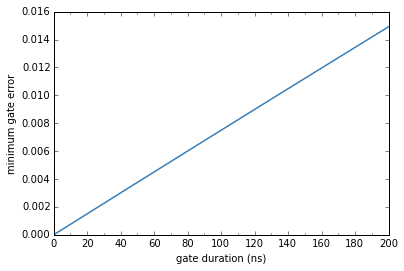

In [7]:
show_diss_error(gamma=1.2e-5, tgrid=np.linspace(0, 200, 1000))

In [8]:
gate_times = [10, 20, 50, 100, 200] # ns
df = pd.DataFrame(index=gate_times,
     data={'minimum error': [diss_error(gamma=1.2e-5, t=t) for t in gate_times]})
df.index.name = "gate duration [ns]"
print df.to_string(float_format=lambda f:'%.2e'%f)

                    minimum error
gate duration [ns]               
10                       7.54e-04
20                       1.51e-03
50                       3.76e-03
100                      7.50e-03
200                      1.49e-02


These errors are for the bare qubit states, the actual minimal error will be (very slightly) larger, and parameter dependent, due to mixing of qubit and cavity levels.

## Stage 1: Random Frequency Search & Amplitude Scan

For each parameters pair ($\omega_2, \omega_c$) we run a `./pre_simplex_scan.py` script, taking the following steps:
*   create runfolders, e.g. `w2_6000MHz_wc_11000MHz/stage1/...`
    
        .../field_free -> determine zeta
        .../1_freq_center <- frequency centered between qubits
        .../1_freq_1..10 <- 10 random frequencies
        .../2_freq_resonant <- resonant with both qubits
        .../2_freq_1..10 <- 10 random frequency pairs
        .../5_freq_1..10 <- 10 random frequency/amplitude choices
        [33 runfolders per parameter set]

*   for each runfolder, scan peak amplitude over values $E_0 =$ 10, 50, 100, 150, 200, 250, 300, 350, 400, 450 MHz   
    [total 10 * 33 propagations per parameter set]

*   select best runs, and create runfolders for stage, e.g. `w2_6000MHz_wc_11000MHz/stage1/...`

        .../PE_1freq_center <- best amplitude for perfect entangler
        .../O_1freq_center <- best amplitude for LEC unity
        .../PE_1freq_random <- best random frequency/amplitude for PE
        .../O_1freq_random
        .../PE_2freq_resonant
        .../O_2freq_resonant
        .../PE_2freq_random
        .../O_2freq_random
        .../PE_5freq_random
        .../O_5freq_random
        [10 runfolders per parameter set]
        

In a first attempt, we ran stage 1 in the lab frame, in the folder `./runs_200_LAB`

In [ ]:
! ./run_stage1.py {cluster_args} --params-file=parameters200.dat --duration=200 ./runs_200_LAB

According to F. Motzoi, operating in the LAB frame is unnecessary. The RWA should at most add a non-entangling shift.

[Are the obtained pulses still valid in a RWA?](RWA_check.ipynb)

It appears that the concurrence and loss are the same in the lab frame and the RWA frame, except when one of the logical populations drops close to zero. We suspect that in this case, the phases (in which the concurrence depends) is different, and thus we obtain different values in the two frames. Note that the concurrene is not well-defined unless that gate is unitary in the logical subspace.

Thus, from now on, we do everything in the rotating frame:

In [ ]:
! ./run_stage1.py {cluster_args} --local --params-file=parameters200.dat --rwa --duration=200 --parallel=1 --jobs=16 ./runs_200_RWA
! ./run_stage1.py {cluster_args} --local --params-file=parameters100.dat --rwa --duration=100 --parallel=1 --jobs=16 ./runs_100_RWA

[Analysis of the stage-1 results](Stage1Analysis.ipynb) indicate that even by just some random pulses, we can substantially increase and decrease the entanglement from the field-free case. The best results are obtained for the cavity being relatively close to the qubits. i.e., *not* in the dispersive regime!

The analysis also shows that we're "good enough" working with a single frequency (which makes analysis of the optimized pulses much easier). We thus only consider single-frequency pulses for shorter gate durations

In [ ]:
! ./run_stage1.py {cluster_args} --params-file=parameters050.dat --single-frequency  --rwa --duration=50 ./runs_050_RWA
! ./run_stage1.py {cluster_args} --params-file=parameters020.dat --single-frequency  --rwa --duration=20 ./runs_020_RWA
! ./run_stage1.py {cluster_args} --params-file=parameters010.dat --single-frequency  --rwa --duration=10 ./runs_010_RWA
! ./run_stage1.py {cluster_args} --params-file=parameters005.dat --single-frequency  --rwa --duration=5  ./runs_005_RWA

We prepare for stage-2 by selecting the most promising candidate for each choice of parameters $(\omega_2, \omega_c)$ and for each pulse category. For each category, and optimizing for full or zero entanglement, we generate a runfolder of the same name, inside a `stage2` subfolder. E.g. `./runs/w2_6100MHz_wc_10100MHz/stage2/PE_2freq_resonant`

In [ ]:
%%bash
./select_for_stage2.py ./runs_200_RWA
./select_for_stage2.py ./runs_100_RWA
./select_for_stage2.py ./runs_050_RWA
./select_for_stage2.py ./runs_020_RWA
./select_for_stage2.py ./runs_010_RWA
./select_for_stage2.py ./runs_005_RWA

## Stage 2: Simplex (Pre-)Optimization

For each parameter pair, and each of the 10 runfolders selected for each parameter pair,

*   run simplex search. The optimization functional to be minimized targets either the perfect entanglers or the equivalence class of the identity (local gates):
    \begin{align}
    J^{splx}_{PE} &= 1 - C (1-\varepsilon^{min}_{pop}) = 1 - C + C \varepsilon^{min}_{pop}\\
    J^{splx}_{SQ} &= 1 - (1-C) (1-\varepsilon^{min}_{pop}) = \varepsilon^{min}_{pop} + C - C \varepsilon^{min}_{pop}
    \end{align}
    where $C$ is the concurrence and
    \begin{equation}
        \varepsilon^{min}_{pop} = \min_i \Vert U \ket{i} \Vert; \qquad \ket{i} \in [00, 01, 10, 11]
    \end{equation}
    is the maximum loss of population from the logical subspace. We use a multiplicative functional because the concurrence is only well-defined for a unitary $U$. In particular, we find that the concurrence can take different values in the RWA and LAB frames if one of the propagated states has a norm $\approx 0$ at the final time (due to the fact that the phase of 0 is undefined)
*   The starting point of the optimization are the pulses selected above; for the different categories, the free parameters are
    * for single-frequency $\epsilon(t) = E_0 B(t) \cos(\omega_L t)$: $E_0$, $\omega_L$ [2 parameters]
    * for 2 frequencies $\epsilon(t) = B(t)(a_1 \cos(\omega_{L,1} t) + a_2 \cos(\omega_{L,2} t + \phi_0)$: $a_1$, $a_2$, $\omega_{L,1}$, $\omega_{L,2}$, $\phi_0$. [5 parameters]
    * for 5 frequencies $\epsilon(t) = B(t)\left[\sum_{n=1}^{3}(a_n \cos(\omega_{L,n} t) + b_n \sin(\omega_{L,n} t))\right] \left[\sum_{n=4}^{5}(a_n \cos(\omega_{L,n} t) + b_n \sin(\omega_{L,n} t))\right]$: $a_{1..5}$, $b_{1..5}$, $\omega_{L,1..5}$ [15 parameters]
    
    For the `5freq` parametrization, the frequencies $\omega_1 .. \omega_3$ are low frequencies that just modulate the pulse shape. The remaining two frequencies are near the qubit of the cavity frequencies.
    
    All pulses use a Blackman envelope $B(t)$


In [ ]:
! ./run_stage2.py {cluster_args} --rwa ./runs_200_RWA
! ./run_stage2.py {cluster_args} --rwa ./runs_100_RWA
! ./run_stage2.py {cluster_args} --rwa ./runs_050_RWA
! ./run_stage2.py {cluster_args} --rwa ./runs_020_RWA
! ./run_stage2.py {cluster_args} --rwa ./runs_010_RWA
! ./run_stage2.py {cluster_args} --rwa ./runs_005_RWA

The optimization used Nelder-Mead-simplex. Powell's method was also tested, but lead to parameters changing into unrealistic regimes.

In order to evaluate the optimization success, we may determine the closest perfect entangler and the closest gate locally equivalent to the identity, and evaluate the average gate fidelity with respect to that gate. Running the `closest_target` script finds all files 'U.dat' in stage2 optimization results (and stage3) and writes either a file `U_closest_PE.dat` or `U_closest_SQ.dat` in the same folder, depending on what it detects the optimization target to have been.

In [ ]:
%%bash
./closest_targets.py runs_200_RWA
./closest_targets.py runs_100_RWA
./closest_targets.py runs_050_RWA
./closest_targets.py runs_020_RWA
./closest_targets.py runs_010_RWA
./closest_targets.py runs_005_RWA

[Analysis of the stage-2 results](Stage2Analysis.ipynb)

At this point, it is a good idea to re-evaluate the validity of the RWA

In [ ]:
! ./check_stage2_rwa.py {cluster_args} runs_200_RWA
! ./check_stage2_rwa.py {cluster_args} runs_100_RWA

In [1]:
from notebook_utils import get_LAB_table
stage2_LAB_table_200 = get_LAB_table('runs_200_RWA')
stage2_LAB_table_100 = get_LAB_table('runs_100_RWA')

In [ ]:
with open("stage2_LAB_table_200.dat", "w") as out_fh:
    out_fh.write(stage2_LAB_table_200.to_string())
with open("stage2_LAB_table_100.dat", "w") as out_fh:
    out_fh.write(stage2_LAB_table_100.to_string())

This shows very good agreement between the RWA frame and the LAB frame!

For stage 3, for each point we only consider the best result from the two pulse categories `1freq_random`/`1freq_center`, creating a runfolder `1freq`, and in the same way from `2freq_random`/`2freq_random`, `2freq` is selected. The name for the 5-frequency runfolder is `5freq`

In [ ]:
%%bash
./select_for_stage3.py ./runs_200_RWA
./select_for_stage3.py ./runs_100_RWA
./select_for_stage3.py ./runs_050_RWA
./select_for_stage3.py ./runs_020_RWA
./select_for_stage3.py ./runs_010_RWA
./select_for_stage3.py ./runs_005_RWA

## Stage 3: Gradient-Based Search

We perform 100 OCT iterations for each stage 3 runfolder

In [ ]:
! ./run_stage3.py {cluster_args} --rwa ./runs_200_RWA
! ./run_stage3.py {cluster_args} --rwa ./runs_100_RWA
! ./run_stage3.py {cluster_args} --rwa ./runs_050_RWA
! ./run_stage3.py {cluster_args} --rwa ./runs_020_RWA
! ./run_stage3.py {cluster_args} --rwa ./runs_010_RWA
! ./run_stage3.py {cluster_args} --rwa ./runs_005_RWA

For the analysis, we again need the closest PE or SQ gates (see stage 2)

In [ ]:
%%bash
./closest_targets.py runs_200_RWA
./closest_targets.py runs_100_RWA
./closest_targets.py runs_050_RWA
./closest_targets.py runs_020_RWA
./closest_targets.py runs_010_RWA
./closest_targets.py runs_005_RWA

[Analysis of stage-3 results](Stage3Analysis.ipynb)

## Stage 4: A Universal Set of Gates

Stage 3, if successful, already gives us a perfect entangler. To get to a full set of universal gates, we must amend this with at least two single-qubit gates
*   The Hadamard gate ($H$)
*   The $\pi/8$ gate ($S$)

We therefore optimize (with the SM functional) the gates $I \otimes H$, $H \otimes I$, $I \otimes S$, $S \otimes I$, where $I$ is the identity on a single qubit. On the off-chance that optimization is successful only for the left or the right qubit, we also optimize directly for the SWAP gate (this proved unsuccesful, so we didn't keep the results).

Actually, it is not entirely clear to me whether this is sufficient. If we just ask about *completeness*, then even a single perfect entangler is sufficient. However, if we ask for efficiency, then only gates on the line $L--A_2$ in the Weyl chamber (the "special PE") are known to be efficient in combination with the above single-qubit gates. For PE's that are not special PE's, I'm not sure to what extent they are efficient or not. [PRA 72, 052323] shows how sqrtSWAP can also be relatively efficient.

First, we prepare stage 4 by selecting the points we are interested in. The interesting points $(\omega_c, \omega_2)$ were selected by hand and are listed in the files `parameters_stage4_010.dat` etc. The selection script scans the `stage3/SQ_*` runfolders for the requested points, and creates new stage4 runfolders for the optimization of the required single-qubit gates. We also continue optimization of the PE gate, switching from the PE functional to optimizing for the closest PE directly.

In [ ]:
%%bash
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_050.dat --stage-folder='stage4' runs_050_RWA
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_020.dat --stage-folder='stage4' runs_020_RWA
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_010.dat --stage-folder='stage4' runs_010_RWA

In [ ]:
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4' runs_010_RWA
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4' runs_020_RWA
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4' runs_050_RWA

As an alternative approach, we can also start again with a simplex, allowing to choose different central frequencies for different single-qubit gates.

In [ ]:
%%bash
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_050.dat --stage-folder='stage4_1freq' runs_050_RWA
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_020.dat --stage-folder='stage4_1freq' runs_020_RWA
./select_for_stage4.py --single-frequency --params-file=parameters_stage4_010.dat --stage-folder='stage4_1freq' runs_010_RWA

In [ ]:
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4_1freq' --pre-simplex='1freq_rwa' runs_050_RWA
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4_1freq' --pre-simplex='1freq_rwa' runs_020_RWA
! ./run_stage4.py {cluster_args} --rwa --stage-folder='stage4_1freq' --pre-simplex='1freq_rwa' runs_010_RWA

The results of stage4 are shown together with the propgation below

A tabular overview of the results from all stages it generated by

In [ ]:
! ./build_table_caches.py --check

## Final stage: Propagation

To understand the obtained gates in detail, we copy all of the stage 4 runfolders to corresponding `stage_prop` folders, and propagate all of them.

* for the "default" guess pulses:

In [ ]:
%%bash
./select_for_prop.py runs_050_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop'
./select_for_prop.py runs_020_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop'
./select_for_prop.py runs_010_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop'

In [ ]:
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop' ./runs_050_RWA
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop' ./runs_020_RWA
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop' ./runs_010_RWA

[Analysis](PropAnalysis.ipynb)

* for the `stage4_1freq` alternative (see above):

In [ ]:
%%bash
./select_for_prop.py runs_050_RWA --stage4-folder='stage4_1freq' --stage-prop-folder='stage_prop_1freq'
./select_for_prop.py runs_020_RWA --stage4-folder='stage4_1freq' --stage-prop-folder='stage_prop_1freq'
./select_for_prop.py runs_010_RWA --stage4-folder='stage4_1freq' --stage-prop-folder='stage_prop_1freq'

In [ ]:
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop_1freq' ./runs_050_RWA
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop_1freq' ./runs_020_RWA
! ./run_prop.py {cluster_args} --rwa --stage-folder='stage_prop_1freq' ./runs_010_RWA

[Analysis](PropAnalysis_1freq.ipynb)

In comparison to the "default" optimization, the "pre-simplex" (`stage4_1freq`) optimization neither yielded good fidelities nor nicer-looking pulses.

Lastly, we ensure that our modelling of the dissipation with a non-Hermitian Hamiltonian is not too far off the mark, by propagating the full density matrix.

In [ ]:
%% bash
./select_for_prop.py runs_050_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho'
./select_for_prop.py runs_020_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho'
./select_for_prop.py runs_010_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho'

In [ ]:
! ./run_prop.py {cluster_args} --rwa --rho --stage-folder='stage_prop_rho' ./runs_050_RWA
! ./run_prop.py {cluster_args} --rwa --rho --stage-folder='stage_prop_rho' ./runs_020_RWA
! ./run_prop.py {cluster_args} --rwa --rho --stage-folder='stage_prop_rho' ./runs_010_RWA

[Analysis](PropAnalysis_rho.ipynb) shows that for fidelities >= 0.99, the "true" fidelity in Liouville space is better than the result we obtained in Hilbert space.

... and again for one additional qubit and cavity level

In [ ]:
%% bash
./select_for_prop.py runs_050_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho_larger'
./select_for_prop.py runs_020_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho_larger'
./select_for_prop.py runs_010_RWA --stage4-folder='stage4' --stage-prop-folder='stage_prop_rho_larger'

In [ ]:
! ./run_prop.py {cluster_args} --rwa --rho --n_qubit=6 --n_cavity=7 --stage-folder='stage_prop_rho_larger' ./runs_050_RWA
! ./run_prop.py {cluster_args} --rwa --rho --n_qubit=6 --n_cavity=7 --stage-folder='stage_prop_rho_larger' ./runs_020_RWA
! ./run_prop.py {cluster_args} --rwa --rho --n_qubit=6 --n_cavity=7 --stage-folder='stage_prop_rho_larger' ./runs_010_RWA